# Jemez SnowEx UAVSAR Analysis

This notebook directly downloads of UAVSAR data using the Alaska Satelitte Facility (ASF) API. It then converts the flat binary data provided by JPL to GeoTiffs. This work came out of the 2021 NASA SnowEx Hackweek

Code By: Jack Tarricone, Paul Billecocq, and Zack Keskinen

In [1]:
# import libraries
import numpy as np
import re
import zipfile
import getpass
from osgeo import gdal 
import os  # for chdir, getcwd, path.basename, path.exists
import pandas as pd # for DatetimeIndex
import codecs # for text parsing code
import netrc
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import glob
import requests
from shapely.geometry import Polygon, mapping
from datetime import datetime
from subprocess import PIPE, Popen

In [2]:
# input NASA Earthdata credentials here
ASF_USER = input("Enter Username: ")
ASF_PASS = getpass.getpass("Enter Password: ")

Enter Username:  jacktarricone
Enter Password:  ············


### Function definitions to query ASF APi

In [3]:
def build_bbox_string(polygon):
    '''
    Builds the string to include in the ASF search request. The bbox consists of 4 comma-separated numbers: lower left longitude,latitude, and upper right longitude,latitude.
    
    Parmeters
    ----------
    polygon: shapely polygon
    
    Returns
    ----------
    polygon_string : string
        String to include in the ASF request
    '''
    points = mapping(polygon)['coordinates'][0]
    lower_left = points[0]
    upper_right = points[2]
    bbox_string = f'{lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]}'
        
    return bbox_string

def search_asf(platform, processingLevel, start, end, polygon, output_format):
    '''
    Search the ASF platform for images given the input parameters
    
    Parameters
    ----------
        platform : string
            Name of the imaging platform. Defaults to UAVSAR, but a list of supported platform is available on the ASF website
        processingLevel : string
            Processing level of the imaging product. 
            Possible values for UAVSAR : (KMZ, PROJECTED, PAULI, PROJECTED_ML5X5, STOKES, AMPLITUDE, BROWSE, COMPLEX, DEM_TIFF, PROJECTED_ML3X3, METADATA, AMPLITUDE_GRD, INTERFEROMETRY, INTERFEROMETRY_GRD, THUMBNAIL)
        start : datetime object
            Start date of the search period.
        end : datetime object
            End date of the search period.
        polygon : shapely polygon defining the Area of Interest,
        output_format: string
            Format being returned by the ASF API. Values : CSV, JSON, KML, METALINK, COUNT, DOWNLOAD, GEOJSON
        
    Returns
    -------
    Ouputs a search file
    '''
    base = 'https://api.daac.asf.alaska.edu/services/search/param'
    start_date = start.strftime('%Y-%m-%dT%H:%M:%SUTC')
    end_date = end.strftime('%Y-%m-%dT%H:%M:%SUTC')
    aoi_string = build_bbox_string(polygon)
    payload = {
        'platform': platform,
        'processingLevel': processingLevel,
        'start': start,
        'end': end,
        'bbox': aoi_string,
        'output': output_format
    }
    r = requests.get(base, params=payload)
    
    return r.json()

def download_single_product(productUrl, path):
    '''
    Downloading function.
    
    Paramters
    ----------
    productUrl: string
            Product download Url
    path: string
            path to download product to
            
    Returns
    -------
    Download the file
    '''
    process = Popen(['wget', productUrl, f'--user={ASF_USER}', f'--password={ASF_PASS}', '-P', path, '--progress=bar'], stderr=PIPE)
    started = False
    for line in process.stderr:
        line = line.decode("utf-8", "replace")
        if started:
            splited = line.split()
            if len(splited) == 9:
                percentage = splited[6]
                speed = splited[7]
                remaining = splited[8]
                print("Downloaded {} with {} per second and {} left.".format(percentage, speed, remaining), end='\r')
        elif line == os.linesep:
            started = True
    print(f"\nDone downloading {productUrl}")
    
def search_and_bulk_download(platform, processingLevel, start, end, polygon, path):
    '''
    Search the ASF platform for images given the input parameters. Download found products
    
    Parameters
    ----------
        platform : string
            Name of the imaging platform. Defaults to UAVSAR, but a list of supported platform is available on the ASF website
        processingLevel : string
            Processing level of the imaging product. 
            Possible values for UAVSAR : (KMZ, PROJECTED, PAULI, PROJECTED_ML5X5, STOKES, AMPLITUDE, BROWSE, COMPLEX, DEM_TIFF, PROJECTED_ML3X3, METADATA, AMPLITUDE_GRD, INTERFEROMETRY, INTERFEROMETRY_GRD, THUMBNAIL)
        start : datetime object
            Start date of the search period.
        end : datetime object
            End date of the search period.
        polygon : shapely polygon defining the Area of Interest,
        path: string
            Path to download product to
        '''
    results = search_asf(platform, processingLevel, start, end, polygon, output_format='JSON')[0]
    print(f'{len(results)} product(s) found')
    for result in results:
        downloadUrl = result['downloadUrl']
        download_single_product(downloadUrl, path)
        print('Unzipping product')
        with zipfile.ZipFile(path + result['fileName'], 'r') as zip_ref:
            zip_ref.extractall(path + result['productName'])
        print('Deleting original .zip')
        os.remove(path + result['fileName'])    

In [4]:
# folder is path to a folder with an .ann (or .txt) and .grd files (.amp1, .amp2, .cor, .unw, .int)

def uavsar_tiff_convert(folder, verbose = False):
    """
    Builds a header file for the input UAVSAR .grd file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .grd and .ann files
    """

    os.chdir(folder)

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".grd":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "Ground Range Data Latitude Lines" in line:
                    Lines = line[65:70]
                    if verbose:
                        print(f"Number of Lines: {Lines}")
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "Ground Range Data Longitude Samples" in line:
                    Samples = line[65:70]
                    if verbose:
                        print(f"Number of Samples: {Samples}")
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "Ground Range Data Starting Latitude" in line:
                    Latitude = line[65:85]
                    if verbose:
                        print(f"Top left lat: {Latitude}")
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "Ground Range Data Starting Longitude" in line:
                    Longitude = line[65:85]
                    if verbose:
                        print(f"Top left Lon: {Longitude}")
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .grd files expect for .int
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    # Step 3: Open .hdr file and replace data for .int file date type 6 (complex)                 
    for files in os.listdir(folder):
        if files[-8:] == ".int.hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = 4" in line:
                        sources.write(re.sub(line[12:13], "6", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    data_to_process = glob.glob(os.path.join(folder, '*.grd')) # list all .grd files
    for data_path in data_to_process: # loop to open and translate .grd to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tif'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    
    # Step 5: Save the .int raster, needs separate save because of the complex format
    data_to_process = glob.glob(os.path.join(folder, '*.int.grd')) # list all .int.grd files (only 1)
    for data_path in data_to_process:
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tif'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_CFloat32)
        
    return

In [5]:
# jemez polygon for testing purposes (bounding box info from .ann)
jemez_polygon = Polygon([(-106.7272, 35.7211),(-106.2372, 35.7211),(-106.2372, 36.0658),(-106.7272, 36.0658)])
start_date = datetime.strptime('2020-02-19 11:00:00', '%Y-%m-%d %H:%M:%S') 
end_date = datetime.strptime('2020-02-26 11:00:00', '%Y-%m-%d %H:%M:%S') 

In [6]:
# query API
result = search_asf(platform='UAVSAR', processingLevel='INTERFEROMETRY_GRD', 
                    start=start_date, end=end_date, polygon=jemez_polygon, output_format='JSON')

In [7]:
# print first result
result[0][0]

{'absoluteOrbit': '-1',
 'beamMode': 'RPI',
 'beamModeType': 'RPI',
 'beamSwath': None,
 'browse': 'https://datapool.asf.alaska.edu/BROWSE/UA/alamos_35915_20008-000_20013-000_0007d_s01_L090HH_01.cor.png',
 'catSceneId': None,
 'centerLat': '35.8884988092287',
 'centerLon': '-106.439472086581',
 'collectionName': 'Los Alamos, NM',
 'configurationName': 'Repeat Pass Interferometry',
 'doppler': '-1',
 'downloadUrl': 'https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/alamos_35915_20008-000_20013-000_0007d_s01_L090_01_int_grd.zip',
 'farEndLat': '36.04360921',
 'farEndLon': '-106.33324373',
 'farStartLat': '35.75907871',
 'farStartLon': '-106.30749763',
 'faradayRotation': None,
 'fileName': 'alamos_35915_20008-000_20013-000_0007d_s01_L090_01_int_grd.zip',
 'finalFrame': '718',
 'firstFrame': '718',
 'flightDirection': None,
 'flightLine': '35915',
 'formatName': None,
 'frameNumber': '718',
 'frequency': None,
 'granuleName': 'UA_alamos_35915_20008-000_20013-000_0007d_s01_L090_01',
 '

In [15]:
print(result[0][0])

{'absoluteOrbit': '-1', 'beamMode': 'RPI', 'beamModeType': 'RPI', 'beamSwath': None, 'browse': 'https://datapool.asf.alaska.edu/BROWSE/UA/alamos_35915_20008-000_20013-000_0007d_s01_L090HH_01.cor.png', 'catSceneId': None, 'centerLat': '35.8884988092287', 'centerLon': '-106.439472086581', 'collectionName': 'Los Alamos, NM', 'configurationName': 'Repeat Pass Interferometry', 'doppler': '-1', 'downloadUrl': 'https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/alamos_35915_20008-000_20013-000_0007d_s01_L090_01_int_grd.zip', 'farEndLat': '36.04360921', 'farEndLon': '-106.33324373', 'farStartLat': '35.75907871', 'farStartLon': '-106.30749763', 'faradayRotation': None, 'fileName': 'alamos_35915_20008-000_20013-000_0007d_s01_L090_01_int_grd.zip', 'finalFrame': '718', 'firstFrame': '718', 'flightDirection': None, 'flightLine': '35915', 'formatName': None, 'frameNumber': '718', 'frequency': None, 'granuleName': 'UA_alamos_35915_20008-000_20013-000_0007d_s01_L090_01', 'granuleType': 'UAVSAR_INSA

In [8]:
# UAVSAR InSAR files are pretty large, so this may take a bit of time
search_and_bulk_download(platform='UAVSAR', processingLevel='INTERFEROMETRY_GRD', 
                         start=start_date, end=end_date, 
                         polygon=jemez_polygon, path='/Users/jacktarricone/jemez_data/')

3 product(s) found
Downloaded 99% with 15.6M per second and 0s left....
Done downloading https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/alamos_35915_20008-000_20013-000_0007d_s01_L090_01_int_grd.zip
Unzipping product
Deleting original .zip
Downloaded 99% with 13.8M per second and 0s left....
Done downloading https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/alamos_35915_20008-000_20013-000_0007d_s01_L090_02_int_grd.zip
Unzipping product
Deleting original .zip
Downloaded 99% with 11.1M per second and 0s left....
Done downloading https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/alamos_35915_20005-003_20008-000_0007d_s01_L090_01_int_grd.zip
Unzipping product
Deleting original .zip


In [24]:
# get new path for folder of insar data just downloaded
new_path_list = glob.glob('/Users/jacktarricone/jemez_data/*')
new_path = new_path_list[1] # select first list elemet
print(new_path)

/Users/jacktarricone/jemez_data/UA_alamos_35915_20008-000_20013-000_0007d_s01_L090_02


In [25]:
# convert files to geotiffs and save in same folder
uavsar_tiff_convert(new_path)

In [23]:
# remove unwanted files
os.chdir(new_path)
grd = glob.glob('*.grd') #define .grd
hdr = glob.glob('*.hdr*') #define .hdr
int_file = glob.glob('*.int*') #define .int

# remove both
for f in grd:
    os.remove(f)
    
for f in hdr:
    os.remove(f)
    
for f in int_file:
    os.remove(f)

## Define only the HH files

In [29]:
# coherence
for cor in glob.glob("*HH*cor.grd.tif"):
    print(cor)

# unwrapped phase
for unw in glob.glob("*HH*unw.grd.tif"):
    print(unw)

# dem used in processing
for dem in glob.glob("*HH*hgt.grd.tif"):
    print(dem)

alamos_35915_20005-003_20008-000_0007d_s01_L090HH_01.cor.grd.tif
alamos_35915_20005-003_20008-000_0007d_s01_L090HH_01.unw.grd.tif
alamos_35915_20005-003_20008-000_0007d_s01_L090HH_01.hgt.grd.tif


In [34]:
# open using rio
cor_rast = rio.open(cor)
unw_rast = rio.open(unw)
dem_rast = rio.open(dem)

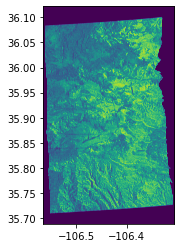

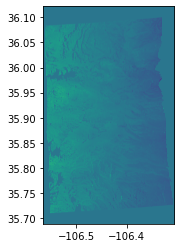

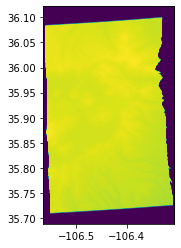

<AxesSubplot:>

In [38]:
# test plot
show(cor_rast)
show(unw_rast)
show(dem_rast)

In [42]:
# unw
with rio.open(unw) as unw_raw:
    unw_array = unw_raw.read(1)

# convert all 0's to nan
unw_array[unw_array==0] = np.nan

#cor
with rio.open(cor) as cor_raw:
    cor_array = cor_raw.read(1)

cor_array[cor_array==0] = np.nan

#dem, no data value is -10000
with rio.open(dem) as dem_raw:
    dem_array = dem_raw.read(1)

dem_array[dem_array == -10000] = np.nan

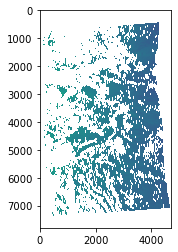

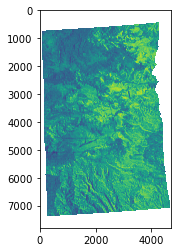

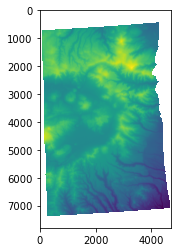

<AxesSubplot:>

In [45]:
# plot NaN corrected data
show(unw_array)
show(cor_array)
show(dem_array)